In [2]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [3]:
nback_keys = []

for k,v in meta.items():
  if 'nback' in v and 'emoid' in v and 'wratStd' in v:
    nback_keys.append(k)

print(len(nback_keys))

620


In [5]:
import numpy as np

nback_p = [np.corrcoef(meta[k]['nback']) for k in nback_keys]
emoid_p = [np.corrcoef(meta[k]['emoid']) for k in nback_keys]

print(nback_p[0].shape)
print(emoid_p[0].shape)

for p in nback_p + emoid_p:
    if np.count_nonzero(np.isnan(p)) > 0:
        print('Nan found')

(264, 264)
(264, 264)


In [6]:
def vectorize_p(p):
        idcs = np.triu_indices(264, 1)
        return p[idcs[0],idcs[1]]

nback_pu = np.stack([vectorize_p(p) for p in nback_p])
emoid_pu = np.stack([vectorize_p(p) for p in emoid_p])

print(nback_pu.shape)
print(emoid_pu.shape)

(620, 34716)
(620, 34716)


In [7]:
age = [meta[k]['AgeInMonths'] for k in nback_keys]
gen = [meta[k]['Gender'] for k in nback_keys]
wrt = [meta[k]['wratStd'] for k in nback_keys]

gen = [[1,0] if g == 'M' else [0,1] for g in gen]

age = np.array(age)
gen = np.array(gen)
wrt = np.array(wrt)

print(age[0:5])
print(gen[0:5])
print(wrt[0:5])

[116 187 190 242 137]
[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]]
[114 145  93  93 100]


In [8]:
# Make splits

idcs = np.arange(age.shape[0])
np.random.shuffle(idcs)
trainValidIdcs = idcs[0:500]
validIdcs = np.arange(400,500)
trainIdcs = trainValidIdcs[0:400]
testIdcs = idcs[500:]

print(trainIdcs[0:5])
print('Complete')

[325 320  91 334 409]
Complete


In [9]:
# Convert to torch

import torch 
import torch.nn as nn 
import torch.nn.functional as F 

nback_p_t = torch.from_numpy(nback_pu).float().cuda()
emoid_p_t = torch.from_numpy(emoid_pu).float().cuda()
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [10]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print('Norm complete')
print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

Norm complete
torch.return_types.min(
values=tensor([-2.3727, -3.0830], device='cuda:0'),
indices=tensor([605, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7864, -3.1093], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [200]:
from itertools import combinations, product

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

rmse = []
features = []

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def arith(n):
    return int(n*(n+1)/2)

def allBelowThresh(losses, thresh):
    for loss,thr in zip(losses, thresh):
        if loss > thr:
            return False
    return True

def getRegLoss(sim, regParam):
    nPerPara = int(sim.w.shape[0]/3)
    tasks = list(combinations(np.arange(nPerPara), 2))
    dims = list(product(np.arange(sim.w.shape[2]), repeat=2))
    loss = []
    for ta,tb in tasks:
        for da,db in dims:
            for p in range(3):
                loss.append(regParam*torch.sum(torch.abs(sim.w[p*nPerPara+ta,:,da]*sim.w[p*nPerPara+tb,:,db])))
    return loss

def getSparseLoss(sim, sparseParam):
    sp = sparseParam
    return ([sp[0]*torch.sum(torch.abs(torch.cat([sim.w[0], sim.w[3], sim.w[6]])))] +
            [sp[1]*torch.sum(torch.abs(torch.cat([sim.w[1], sim.w[4], sim.w[7]])))] +
            [sp[2]*torch.sum(torch.abs(torch.cat([sim.w[2], sim.w[5], sim.w[8]])))])

def getAlignLoss(zs, alignParam):
    loss = []
    para = list(combinations(3*np.arange(3), 2))
    for task in range(3):
        ap = alignParam[task]
        for pa,pb in para:
            loss.append(ap*torch.sum((zs[pa+task]-zs[pb+task])**2))
    return loss

def getAvg(res, nTasks):
    nPara = int(len(res)/nTasks)
    avg = nTasks*[0]
    for p in range(nPara):
        for t in range(nTasks):
            avg[t] += res[p*nTasks+t]/nPara
    return avg

class LatSim(nn.Module):
    def __init__(self, nTasks, inp, dp=0.5, edp=0.1, wInit=1e-4, dim=2, temp=1):
        super(LatSim, self).__init__()
        self.nTasks = nTasks
        self.w = nn.Parameter(wInit*torch.randn(3*nTasks,inp.shape[-1],dim).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
        self.t = temp if isinstance(temp, list) else nTasks*[temp]
    
    def getLatentsAndEdges(self, x, i, w=None):
        if w is None:
            w = self.w[i]
        e = 1e-10
        z = x@w
        e = e+z@z.T
        return z, e
        
    def forward(self, x, ys, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        zs = []
        for para in range(3):
            for i,y in enumerate(ys):
                z, e = self.getLatentsAndEdges(x[:,para], i+para*nTasks)
                zs.append(z)
                if testIdcs is not None:
                    e[:,testIdcs] = 0
                e = mask(e)
                # es.append(e.clone())
                e = self.edp(e)
                e[e == 0] = float('-inf')
                e = F.softmax(e/self.t[i], dim=1)
                res.append(e@y)
        return res, es, zs

def validate(model, X, ys, testIdcs):
    model.eval()
    losses = []
    with torch.no_grad():
        res, _, _ = model(X, ys, testIdcs)
        for r,y in zip(getAvg(res, nTasks), ys):
            if y.dim() == 1:
                loss = mseLoss(r[testIdcs], y[testIdcs]).cpu().numpy()**0.5
                losses.append(loss)
            else:
                corr = (torch.argmax(r, dim=1) == torch.argmax(y, dim=1))[testIdcs]
                loss = torch.sum(corr)/len(testIdcs)
                losses.append(loss)
    model.train()
    return losses

nEpochs = 200
pPeriod = 5
thresh = [20,0.3,10]
regParam = 3e2
sparseParam = [1e1,1e1,1e1]
alignParam = [1e-1,1e-1,1e-1]

# Feature extraction

def featureExtract(sim, task=0, para=0, dim=0):
    tasks = [age_t.unsqueeze(1), gen_t, wrt_t.unsqueeze(1)]

#     sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{task}.pyt'))

    d = torch.cdist(tasks[task], tasks[task])
    d = d - torch.mean(d)
    m = torch.einsum('ad,d->ad', nback_p_t, sim.w[para*3+task,:,dim])
    whole = []
    for i0 in range(0,34700,1000):
        i1 = i0+1000
        mm = torch.einsum('ad,bd->abd', m[:,i0:i1], m[:,i0:i1])
        part = torch.einsum('ab,abd->d', d, mm)
        whole.append(part)
    whole = torch.cat(whole).detach().cpu().numpy()
    return whole

# New split

for nsplit in range(50):
    idcs = np.arange(age.shape[0])
    np.random.shuffle(idcs)
    trainValidIdcs = idcs[0:500]
    validIdcs = np.arange(400,500)
    trainIdcs = trainValidIdcs[0:400]
    testIdcs = idcs[500:]

    X = torch.stack([nback_p_t, emoid_p_t, nback_p_t+emoid_p_t], dim=1)
    Xt = X[trainIdcs]
    Xtv = X[trainValidIdcs]

    yy = [age_t, gen_t, wrt_t]
    yt = [age_t[trainIdcs], gen_t[trainIdcs], wrt_t[trainIdcs]]
    ytv = [age_t[trainValidIdcs], gen_t[trainValidIdcs], wrt_t[trainValidIdcs]]

    nTasks = 3

    sim = LatSim(nTasks, X, dp=0.5, edp=0.1, wInit=1e-4, dim=2, temp=[1,1,1])
    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4)

    validLoss = [[] for _ in range(nTasks)]

    for epoch in range(nEpochs):
        optim.zero_grad()
        res, _, zs = sim(Xt, yt)
        loss = []
        for i,(r,y) in enumerate(zip(res+getAvg(res,nTasks), yt+yt+yt)):
            if y.dim() > 1:
                loss.append(2000*ceLoss(r, y))
            elif i%3 == 0:
                loss.append(mseLoss(r, y))
            else:
                loss.append(20*mseLoss(r, y))
        loss += getRegLoss(sim, regParam)
        loss += getSparseLoss(sim, sparseParam)
#         loss += getAlignLoss(zs, alignParam)
        sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or allBelowThresh(loss[0:nTasks], thresh):
    #         print(f'epoch {epoch} loss={loss}')
            losses = validate(sim, Xtv, ytv, validIdcs)
            for i,lss in enumerate(losses):
                if (len(validLoss[i]) == 0 or 
                    (yy[i].dim() == 1 and lss < min(validLoss[i])) or 
                    (yy[i].dim() > 1 and lss > max(validLoss[i]))):
                    print(f'New best validation epoch {epoch} {i} loss={lss}')
                    torch.save(sim.state_dict(), f'../../Work/LatentSim/sim{i}.pyt')
                    validLoss[i].append(float(lss))
        if allBelowThresh(loss[0:nTasks], thresh):
            print('Early stopping')
            break

    print('Finished training')

    finalLoss = []
    featPart = []

    for task in range(nTasks):
        sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{task}.pyt'))
        loss = validate(sim, X, yy, testIdcs)
        finalLoss.append(float(loss[task]))
        
        for para in range(2):
            feat0 = featureExtract(sim, task, para, 0)
            feat1 = featureExtract(sim, task, para, 1)
            featPart.append((feat0+feat1)/2)
    
    features.append(np.stack(featPart))
    rmse.append(np.array(finalLoss))

    print(f'FINISHED {nsplit} {rmse[-1]}')

New best validation epoch 0 0 loss=35.20027160644531
New best validation epoch 0 1 loss=0.5299999713897705
New best validation epoch 0 2 loss=15.54145622253418
New best validation epoch 5 0 loss=32.80315399169922
New best validation epoch 5 1 loss=0.6200000047683716
New best validation epoch 5 2 loss=14.668017387390137
New best validation epoch 10 0 loss=28.732837677001953
New best validation epoch 10 1 loss=0.7299999594688416
New best validation epoch 10 2 loss=13.75290298461914
New best validation epoch 15 0 loss=26.230600357055664
New best validation epoch 15 1 loss=0.8199999928474426
New best validation epoch 25 0 loss=25.67975616455078
New best validation epoch 30 0 loss=25.02522850036621
New best validation epoch 35 0 loss=24.459508895874023
New best validation epoch 45 0 loss=24.40127944946289
New best validation epoch 50 0 loss=24.246553421020508
New best validation epoch 65 0 loss=24.207530975341797
New best validation epoch 75 0 loss=24.136911392211914
New best validation epo

New best validation epoch 10 0 loss=34.07439422607422
New best validation epoch 10 1 loss=0.6800000071525574
New best validation epoch 10 2 loss=13.6832914352417
New best validation epoch 15 0 loss=31.085744857788086
New best validation epoch 15 1 loss=0.7699999809265137
New best validation epoch 20 0 loss=28.964168548583984
New best validation epoch 20 1 loss=0.7899999618530273
New best validation epoch 20 2 loss=13.64986515045166
New best validation epoch 25 0 loss=28.024402618408203
New best validation epoch 25 2 loss=13.445478439331055
New best validation epoch 30 0 loss=26.51239013671875
New best validation epoch 30 1 loss=0.8299999833106995
New best validation epoch 30 2 loss=13.402782440185547
New best validation epoch 35 0 loss=26.2402400970459
New best validation epoch 40 2 loss=13.32552433013916
New best validation epoch 45 2 loss=13.320538520812988
New best validation epoch 55 0 loss=26.194074630737305
New best validation epoch 55 2 loss=13.303757667541504
New best validatio

New best validation epoch 60 1 loss=0.7999999523162842
New best validation epoch 85 0 loss=28.22200584411621
New best validation epoch 90 0 loss=27.13143539428711
New best validation epoch 95 0 loss=26.268136978149414
New best validation epoch 100 0 loss=26.231382369995117
New best validation epoch 115 0 loss=25.96866798400879
New best validation epoch 140 0 loss=25.941600799560547
Finished training
FINISHED 12 [26.93547249  0.85000002 14.92110634]
New best validation epoch 0 0 loss=36.12129211425781
New best validation epoch 0 1 loss=0.47999998927116394
New best validation epoch 0 2 loss=14.929388999938965
New best validation epoch 5 0 loss=35.13731384277344
New best validation epoch 5 1 loss=0.5399999618530273
New best validation epoch 5 2 loss=14.863080978393555
New best validation epoch 10 0 loss=30.551321029663086
New best validation epoch 10 1 loss=0.7400000095367432
New best validation epoch 10 2 loss=13.984586715698242
New best validation epoch 15 0 loss=28.702037811279297
New 

New best validation epoch 10 0 loss=34.55300521850586
New best validation epoch 10 1 loss=0.7799999713897705
New best validation epoch 15 0 loss=31.400205612182617
New best validation epoch 20 0 loss=29.380470275878906
New best validation epoch 25 0 loss=28.785064697265625
New best validation epoch 30 0 loss=27.926103591918945
New best validation epoch 45 0 loss=27.54238510131836
New best validation epoch 50 0 loss=27.269132614135742
New best validation epoch 55 0 loss=27.199546813964844
New best validation epoch 60 0 loss=27.07443618774414
New best validation epoch 65 0 loss=26.744733810424805
New best validation epoch 70 0 loss=26.646318435668945
New best validation epoch 75 0 loss=26.471555709838867
New best validation epoch 80 0 loss=26.393753051757812
Finished training
FINISHED 19 [25.13272095  0.76666671 15.01869297]
New best validation epoch 0 0 loss=38.035945892333984
New best validation epoch 0 1 loss=0.5099999904632568
New best validation epoch 0 2 loss=16.160400390625
New be

New best validation epoch 10 0 loss=37.36996078491211
New best validation epoch 10 1 loss=0.7099999785423279
New best validation epoch 15 0 loss=28.007265090942383
New best validation epoch 15 1 loss=0.7400000095367432
New best validation epoch 20 0 loss=25.614971160888672
New best validation epoch 20 1 loss=0.7599999904632568
New best validation epoch 20 2 loss=14.240276336669922
New best validation epoch 25 1 loss=0.7699999809265137
New best validation epoch 25 2 loss=14.03609848022461
New best validation epoch 30 0 loss=25.20558738708496
New best validation epoch 30 1 loss=0.7899999618530273
New best validation epoch 30 2 loss=13.919611930847168
New best validation epoch 35 0 loss=24.322317123413086
New best validation epoch 45 1 loss=0.7999999523162842
New best validation epoch 50 1 loss=0.8100000023841858
New best validation epoch 55 1 loss=0.8199999928474426
Finished training
FINISHED 26 [23.79794121  0.7166667  14.19929123]
New best validation epoch 0 0 loss=37.51237106323242
Ne

New best validation epoch 25 0 loss=26.049678802490234
New best validation epoch 25 2 loss=14.641175270080566
New best validation epoch 30 0 loss=25.245559692382812
Finished training
FINISHED 33 [25.41492271  0.77500004 15.0125618 ]
New best validation epoch 0 0 loss=36.246707916259766
New best validation epoch 0 1 loss=0.3999999761581421
New best validation epoch 0 2 loss=16.581960678100586
New best validation epoch 5 0 loss=34.2724723815918
New best validation epoch 5 1 loss=0.5699999928474426
New best validation epoch 5 2 loss=15.366823196411133
New best validation epoch 10 0 loss=29.172494888305664
New best validation epoch 10 1 loss=0.6899999976158142
New best validation epoch 10 2 loss=15.359807968139648
New best validation epoch 15 0 loss=25.559585571289062
New best validation epoch 15 1 loss=0.7699999809265137
New best validation epoch 15 2 loss=14.865345001220703
New best validation epoch 20 0 loss=23.517837524414062
New best validation epoch 20 1 loss=0.7799999713897705
New b

Finished training
FINISHED 39 [23.60111427  0.75833338 15.08293724]
New best validation epoch 0 0 loss=35.79376983642578
New best validation epoch 0 1 loss=0.5699999928474426
New best validation epoch 0 2 loss=14.260610580444336
New best validation epoch 5 2 loss=13.264673233032227
New best validation epoch 10 0 loss=35.714847564697266
New best validation epoch 10 1 loss=0.6599999666213989
New best validation epoch 10 2 loss=13.118128776550293
New best validation epoch 15 0 loss=31.34680938720703
New best validation epoch 15 1 loss=0.7599999904632568
New best validation epoch 20 0 loss=25.6646728515625
New best validation epoch 20 1 loss=0.7799999713897705
New best validation epoch 25 1 loss=0.7899999618530273
New best validation epoch 30 1 loss=0.8199999928474426
New best validation epoch 35 0 loss=25.210275650024414
New best validation epoch 60 0 loss=25.196149826049805
New best validation epoch 65 0 loss=24.98298454284668
New best validation epoch 70 0 loss=24.861291885375977
New be

New best validation epoch 40 1 loss=0.699999988079071
New best validation epoch 60 1 loss=0.7199999690055847
New best validation epoch 75 1 loss=0.7299999594688416
New best validation epoch 125 2 loss=13.745735168457031
New best validation epoch 135 2 loss=13.693802833557129
New best validation epoch 160 2 loss=13.665874481201172
New best validation epoch 175 1 loss=0.7400000095367432
Finished training
FINISHED 46 [24.34038734  0.77500004 13.03269672]
New best validation epoch 0 0 loss=37.55955505371094
New best validation epoch 0 1 loss=0.4699999988079071
New best validation epoch 0 2 loss=16.014747619628906
New best validation epoch 5 1 loss=0.5899999737739563
New best validation epoch 5 2 loss=14.719306945800781
New best validation epoch 10 0 loss=35.391780853271484
New best validation epoch 10 1 loss=0.699999988079071
New best validation epoch 15 0 loss=28.7122859954834
New best validation epoch 15 1 loss=0.7299999594688416
New best validation epoch 20 0 loss=26.728626251220703
New

In [201]:
rmse = np.stack(rmse)
print(np.mean(rmse, axis=0))

[25.28301254  0.79283338 14.34906853]


In [202]:
features = np.stack(features)
meanFeatures = np.mean(features, axis=0)
print(meanFeatures.shape)

(6, 34716)


In [210]:
print(np.min(meanFeatures[5]))

-0.34902686


In [217]:
a[18731],b[18731]

(84, 210)

In [351]:
# Connection distribution

import matplotlib.pyplot as plt

counts = np.zeros(14)

task = 2
para = 1

feat = meanFeatures[task*2+para]
idcs = np.argsort(feat)
# print(idcs[0:50])
# print(feat[idcs[0:50]])
print(idcs[0:50])

def transform(idx):
    return revMap1[a[idx]]+1, revMap1[b[idx]]+1

lbl = ['SMT', 'CNG', 'AUD', 'DMN', 'MEM', 'VIS', 'FRNT', 'SAL', 'SUB', 'VTRL', 'DRSL', 'CB', 'UNK']

def transformLabel(idx):
    ar1 = roiMap2[a[idx]+1]-2
    if ar1 < 0:
        ar1 = 0
    ar2 = roiMap2[b[idx]+1]-2
    if ar2 < 0:
        ar2 = 0
    return f'{lbl[ar1]}-{lbl[ar2]}'

print(roiMap2[a[idcs[0]]])
print(a[idcs[0]])
print(b[idcs[0]])
print(transform(idcs[0]))
print(transform(idcs[4]))
print(transformLabel(idcs[0]))
print(transformLabel(idcs[4]))

# counts += np.bincount(roiMap2[a[idcs[0:10]]+1]-1,minlength=14)
# counts += np.bincount(roiMap2[b[idcs[0:10]]+1]-1,minlength=14)

# fig, ax = plt.subplots(2,1,figsize=(5,8))
# ax[0].stem(-feat[idcs[0:50]], markerfmt='.')
# ax[1].bar(np.arange(0,14),counts)
# fig.show()

[ 9966 11041 10407 11030 20542 20186 10626 23702  7667 24205  2182 21996
  7216 18257 34516  9044 18975  6560 11027 17880  3126  7103 18103 21533
 21515  6047 24294 18266  7212 20543 31215  2171 23546 24204 19070  7654
 26287 20550  7666 30907 23469  7147  7219  3154 20883 20562 22482  3854
  7156 21041]
1
41
45
(31, 35)
(83, 106)
SMT-SMT
DMN-DMN


In [346]:
revMap1[138]

119

In [295]:
import numpy as np

roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap1 = np.zeros(264,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []
roiCounts = np.zeros(14)

with open('../../PNC/PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiCounts[area-1] += 1
        roiNames[area] = name
        revMap1[r2-1] = r1-1
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])

last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

def rearrange(p,idcs):
    return p[:,idcs][idcs]

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


In [168]:
print(roiNames)
print(roiCounts)

{1: 'Sensory/somatomotor Hand', 2: 'Sensory/somatomotor Mouth', 3: 'Cingulo-opercular Task Control', 4: 'Auditory', 5: 'Default mode', 6: 'Memory retrieval?', 7: 'Visual', 8: 'Fronto-parietal Task Control', 9: 'Salience', 10: 'Subcortical', 11: 'Ventral attention', 12: 'Dorsal attention', 13: 'Cerebellar', 14: 'Uncertain'}
[30.  5. 14. 13. 58.  5. 31. 25. 18. 13.  9. 11.  4. 28.]


[ 28  45  26 179  30 115  36 120  82 181]
[-0.01622876 -0.01572949 -0.01109188 -0.01020005 -0.00974986 -0.00945738
 -0.00902273 -0.00893709 -0.00860191 -0.00859751]
[-0.04609323 -0.01572949  0.          0.         -0.08588309  0.
  0.         -0.01879756  0.          0.          0.          0.
  0.         -0.01400836]


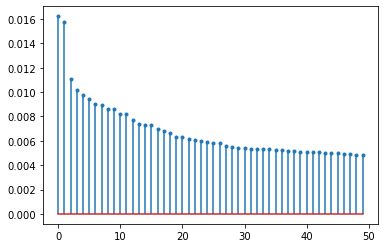

In [235]:
# Average regions

import matplotlib.pyplot as plt

task = 2
para = 1

feat = meanFeatures[task*2+para]

a,b = np.triu_indices(264, 1)
i = np.arange(0,34716)
img = np.zeros((264,264))
img[a[i],b[i]] = feat
img = img+img.T

meanImg = np.mean(img, axis=1)

idcs = np.argsort(meanImg)
print(idcs[:10])
print(meanImg[idcs[:10]])

byNetwork = np.zeros(14)
for net,val in zip(roiMap2[idcs[:20]]-1, list(meanImg[idcs[:20]])):
    byNetwork[net] += val
print(byNetwork)

plt.stem(-meanImg[idcs[0:50]], markerfmt='.')
plt.show()

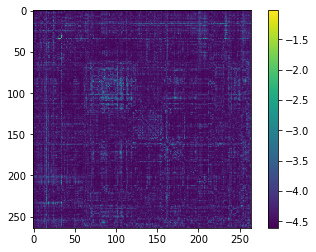

In [234]:
import matplotlib.pyplot as plt

task = 2
para = 1

feat = meanFeatures[task*2+para]

a,b = np.triu_indices(264, 1)
i = np.arange(0,34716)
img = np.zeros((264,264))
img[a[i],b[i]] = feat
img = img+img.T
plt.imshow(rearrange(np.log(-img+1e-2), revMap2))
plt.colorbar()
plt.show()

/tmp/ipykernel_1989/1964709876.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


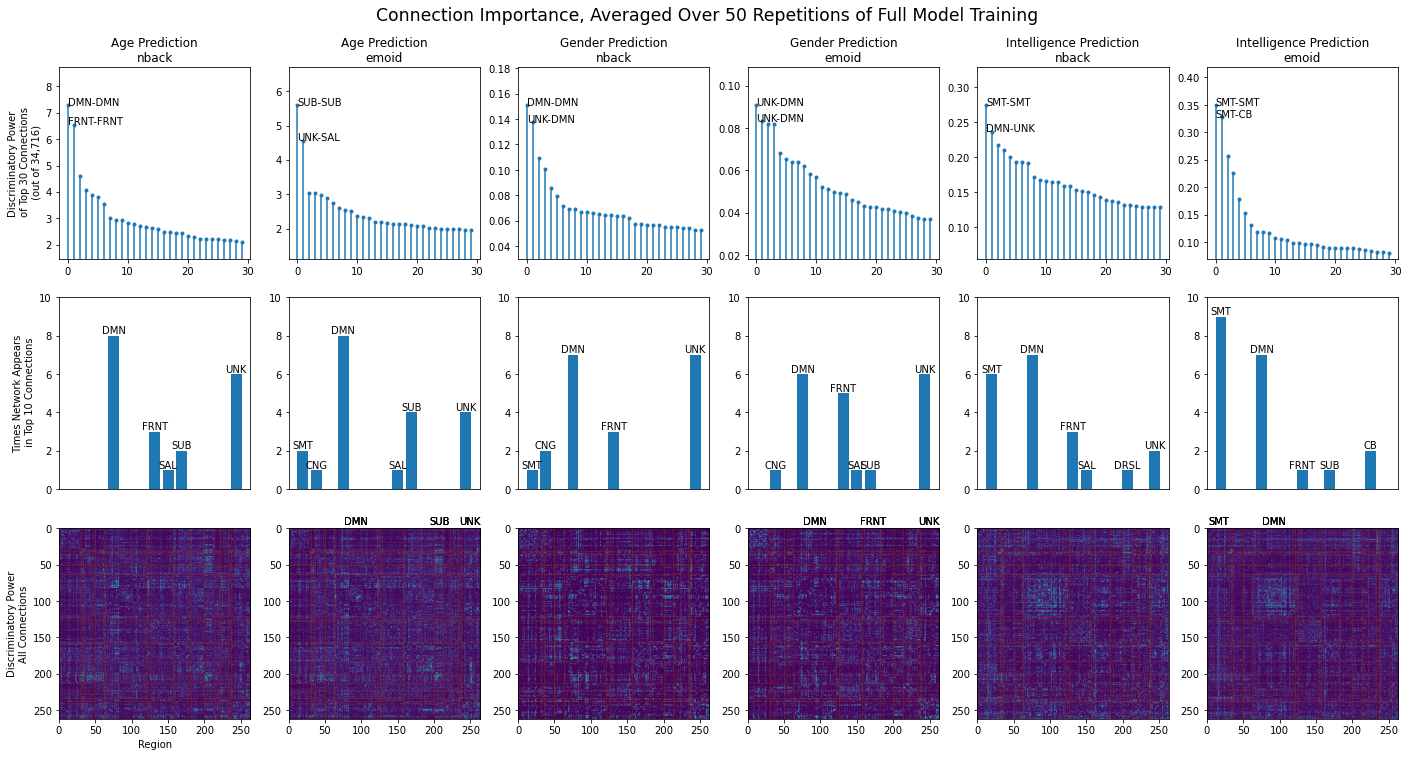

In [338]:
import matplotlib.pyplot as plt
import copy

fig, ax = plt.subplots(3,6,figsize=(24,12))

a,b = np.triu_indices(264, 1)
i = np.arange(0,34716)
contrast = [2e-1,2e-1,2e-3,2e-3,1e-2,1e-2]

lbl = ['SMT', 'CNG', 'AUD', 'DMN', 'MEM', 'VIS', 'FRNT', 'SAL', 'SUB', 'VTRL', 'DRSL', 'CB', 'UNK']
    
for task in range(3):
    for para in range(2):
        idx = task*2+para
        feat = meanFeatures[idx]
        idcs = np.argsort(feat)

        counts = np.zeros(14)
        counts += np.bincount(roiMap2[a[idcs[0:10]]+1]-1,minlength=14)
        counts += np.bincount(roiMap2[b[idcs[0:10]]+1]-1,minlength=14)
        counts = np.concatenate([counts[0:1]+counts[1:2],counts[2:]])

        ax[0,idx].stem(-feat[idcs[0:30]], basefmt=' ', markerfmt='.')
        ax[0,idx].annotate(transformLabel(idcs[0]),(0,-feat[idcs[0]]))
        ax[0,idx].annotate(transformLabel(idcs[1]),(0,-feat[idcs[1]]))
        
        big = -feat[idcs[0]]
        ax[0,idx].set_ylim([0.2*big,1.2*big])
        
        bar = ax[1,idx].bar(np.arange(0,13),counts)
        
        lblCopy = [lab if counts[i] > 0 else '' for i,lab in enumerate(lbl)]
        ax[1,idx].bar_label(bar, lblCopy)
        ax[1,idx].set_ylim(0,10)
        ax[1,idx].set_xticks([])
        
        img = np.zeros((264,264))
        img[a[i],b[i]] = feat
        img = img+img.T
        ax[2,idx].imshow(rearrange(np.log(-img+contrast[idx]), revMap2))
        
        for bidx,bord in enumerate(borders1):
            if bidx == 0:
                continue
            ax[2,idx].plot([0,263],[bord,bord],color='#822',linewidth=0.5)
            ax[2,idx].plot([bord,bord],[0,263],color='#822',linewidth=0.5)
        ax[2,idx].set_xlim(0,263)
        ax[2,idx].set_ylim(262,0)
        
    ax[0,0].set_ylabel('Discriminatory Power\n of Top 30 Connections\n (out of 34,716)')
    ax[1,0].set_ylabel('Times Network Appears\n in Top 10 Connections')
    ax[2,0].set_ylabel('Discriminatory Power\nAll Connections')
    ax[2,0].set_xlabel('Region')
    
    ax[0,0].set_title('Age Prediction\nnback')
    ax[0,1].set_title('Age Prediction\nemoid')
    ax[0,2].set_title('Gender Prediction\nnback')
    ax[0,3].set_title('Gender Prediction\nemoid')
    ax[0,4].set_title('Intelligence Prediction\nnback')
    ax[0,5].set_title('Intelligence Prediction\nemoid')
    
    ax[2,1].text(76,-5,'DMN')
    ax[2,1].text(193,-5,'SUB')
    ax[2,1].text(235,-5,'UNK')
    
    ax[2,3].text(76,-5,'DMN')
    ax[2,3].text(155,-5,'FRNT')
    ax[2,3].text(235,-5,'UNK')
    
    ax[2,5].text(2,-5,'SMT')
    ax[2,5].text(76,-5,'DMN')
    
fig.suptitle('Connection Importance, Averaged Over 50 Repetitions of Full Model Training', fontsize='xx-large', y=0.95)
# fig.savefig('../../Work/LatentSim/Final/FigureBigImportant.eps', bbox_inches='tight')
fig.show()

/tmp/ipykernel_1989/2563219704.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


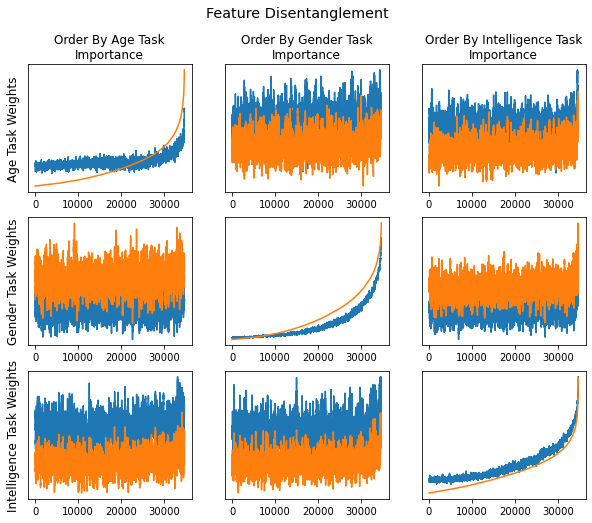

In [22]:
# Plot weights

from scipy.ndimage import convolve1d

task = 0
kern = np.ones(50)/50

sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{task}.pyt'))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nTasks,3,figsize=(10,8))

for task in range(3):
    idcs = np.argsort(np.abs(sim.w[task,:,-1].detach().cpu().numpy()))

    for i in range(nTasks):
        w = sim.w[i].detach().cpu().numpy()
        for j in range(sim.w.shape[2]):
            ax[i][task].plot(convolve1d(np.abs(w[idcs,j]), kern))
            ax[i][task].set_yticks([])

ax[0,0].set_title('Order By Age Task\nImportance')
ax[0,1].set_title('Order By Gender Task\nImportance')
ax[0,2].set_title('Order By Intelligence Task\nImportance')
ax[0,0].set_ylabel('Age Task Weights', fontsize='large')
ax[1,0].set_ylabel('Gender Task Weights', fontsize='large')
ax[2,0].set_ylabel('Intelligence Task Weights', fontsize='large')
fig.suptitle('Feature Disentanglement', y=0.98, fontsize='x-large')
fig.show()
# fig.savefig('drive/MyDrive/Tulane/Research/Work/LatentSim/disentangle.eps', bbox_inches='tight')

In [29]:
para = 0
task = 0
dim = 0

tasks = [age_t.unsqueeze(1), gen_t, wrt_t.unsqueeze(1)]

sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{task}.pyt'))

d = torch.cdist(tasks[task], tasks[task])
d = d - torch.mean(d)
m = torch.einsum('ad,d->ad', nback_p_t, sim.w[para*3+task,:,dim])
whole = []
for i0 in range(0,34700,1000):
    i1 = i0+1000
    mm = torch.einsum('ad,bd->abd', m[:,i0:i1], m[:,i0:i1])
    part = torch.einsum('ab,abd->d', d, mm)
    whole.append(part)
    if i0%10000 == 0:
        print(i0)

whole = torch.cat(whole)
idcs = torch.argsort(whole)
print(idcs[-50:])
whole[idcs[-50:]]

0
10000
20000
30000
tensor([20836, 13189, 25670, 26715, 17965, 16932, 32467, 21842, 12467, 10309,
        31926, 30237,  3449, 34068, 15668, 25489, 23571,  2839, 27801,   671,
        18467,  3698, 14651,  1035,  1818, 13283, 31563,  4470, 33158, 23801,
         5547, 16103, 29662, 32498, 12638, 10321, 19843, 17498, 19246, 22953,
        28656, 25266, 31316, 27758,  6161, 34021,  4135,   996,  3311,  3121],
       device='cuda:0')


tensor([-2.6758e-08, -2.6704e-08, -2.6055e-08, -2.6021e-08, -2.5677e-08,
        -2.3013e-08, -2.2025e-08, -2.1141e-08, -2.1055e-08, -2.0226e-08,
        -1.9741e-08, -1.8656e-08, -1.8049e-08, -1.7297e-08, -1.6178e-08,
        -1.6177e-08, -1.5853e-08, -1.4811e-08, -1.3855e-08, -1.3633e-08,
        -1.3092e-08, -1.2963e-08, -1.2297e-08, -1.0624e-08, -1.0477e-08,
        -1.0051e-08, -9.1920e-09, -9.1209e-09, -8.9784e-09, -7.4660e-09,
        -6.5871e-09, -6.0790e-09, -5.6110e-09, -5.5072e-09, -5.3174e-09,
        -5.0489e-09, -4.9493e-09, -4.7743e-09, -3.4083e-09, -2.6080e-09,
        -1.9014e-09, -1.5695e-09, -1.3127e-09, -1.3115e-09, -1.1924e-09,
        -9.5949e-10, -8.6407e-10, -2.0342e-10, -1.6041e-10, -4.1111e-11],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [32]:
reg = 996
a, b = np.triu_indices(264, 1)
print((a[reg],b[reg]))

(3, 214)
